In [29]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
import jax.numpy as jnp
import jax
import numpyro

from numpyro import handlers
from numpyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt
from functions import *
from utils import *

XLA_PYTHON_CLIENT_MEM_FRACTION=.25

jax.config.update("jax_debug_nans", True)

def logprior(dmap_flat, num_probes):
    """
    """
    return jnp.sum(jnp.array(logprior_(dmap_flat, num_probes)))

@partial(jax.jit, static_argnums=(1, ))
def logprior_(dmap_flat, num_probes):
    """
    """
    # Get 2D map back to simplify the expression 
    dmap = jnp.reshape(dmap_flat, [num_probes, num_probes])
    
    # Calculate the squared end-to-end distance 
    R_sq = dmap[0][-1] ** 2
    
    # Calculate the average bond length
    b = jnp.mean(jnp.diag(dmap, 1))
    
    N = num_probes
    
    # Calculate the probability
    scaling_factor = 1.5 * jnp.log(3/(2*np.pi*N*b**2))
    gaussian_term = -3*R_sq/(2*N*b**2)
    
    # print('Scaling factor = {}'.format(scaling_factor))
    # print('Gaussian term = {}'.format(gaussian_term))
    
    return scaling_factor, gaussian_term 

def gsm_helper(x, num_components, dimensions):
    # make sure the dimensions are correct
    # assert x.shape[0] == num_components * dimensions
    num_samples = x.shape[0]
    
    # # reshape the input
    # x = jnp.reshape(x, [num_components, dimensions])
    
    vmap_batch_lp = jax.vmap(log_posterior, in_axes=(0, None, None, None, None, None, None))
    
    # calculate the log posterior 
    # change this argument in real function 
    lp = jnp.sum(vmap_batch_lp(x, observation_flatten_list, true_weights, measurement_error, num_probes, num_components, dimensions))
    
    return lp

def log_posterior(metastructures, observations, metastructure_weights,
                  measurement_error, num_probes, num_components, dimensions):
    """
    Calculate the logarithm of the posterior probability distribution.

    Parameters
    ----------
    metastructures : 2-dimension array_like
        The metastructures representing the chromatin ensemble.
    observations : array_like
        The flattened observations.
    metastructure_weights : array_like
        The number of observations for each probe.
    measurement_error : float
        The measurement error.
    num_probes : int
        The number of probes.

    Returns
    -------
    float
        The logarithm of the posterior probability distribution.
    """
    metastructures = jnp.array(metastructures)
    # jax.debug.print("{x}", x=metastructures.shape)
    metastructures = jnp.reshape(metastructures, [num_components, dimensions])
    
    # Make sure metastructures, observations, and metastructure_weights are jnp arrays
    
    observations = jnp.array(observations)
    # jax.debug.print("{x}", x=observations.shape)
    metastructure_weights = jnp.array(metastructure_weights)
    metastructure_weights = jnp.reshape(metastructure_weights, [num_components, 1])
    jax.debug.print("{x}", x=metastructure_weights.sum())
    jax.debug.print("{x}", x=metastructure_weights)
    # make sure that metastructure_weights is > 0
    # metastructure_weights = jnp.abs(metastructure_weights)
    # metastructure_weights += jnp.finfo(jnp.float64).tiny
    
    # Set weight prior to be categorical distribution
    weight_prior = 1/len(metastructure_weights)
    
    # Calculate log posterior in batch using vmap
    vmap_batch_log_posterior = jit(jax.vmap(log_posterior_one_obs, in_axes=(None, 0, None, None, None, None)), static_argnums=(3, 4, 5))
    lp = vmap_batch_log_posterior(metastructures, observations, metastructure_weights, weight_prior, measurement_error, num_probes)
    # jax.debug.print("log prob = {x}, {y}", x=lp, y=metastructure_weights)
    log_posterior_total = jnp.sum(lp)
    
    return log_posterior_total

# Write a helper function to calculate the argument for logsumexp function for each metastructure
def _log_posterior_one_obs_helper(metastructure, observation, metastructure_weight, weight_prior,
                  measurement_error, num_probes):
    """_summary_

    Args:
        metastructures (_type_): _description_
        observations (_type_): _description_
        metastructure_weights (_type_): _description_
        measurement_error (_type_): _description_
        num_probes (_type_): _description_
        batch_size (_type_): _description_
    """
    # Calculate log weights 
    lw = jnp.log(metastructure_weight)
    
    # Calculate log likelihood
    lp = loglikelihood(observation, metastructure, measurement_error, num_probes)
    
    # Calculate log prior weights
    lpw = jnp.log(weight_prior)
    
    # Calculate log prior for metastructure
    lpm = logprior(metastructure, num_probes)
    
    # jax.debug.print("log prob = {x},\n log prior weight = {y},\n log prior metastructure = {z},\n log weights = {a}", x=lp, y=lpw, z=lpm, a=lw)
    
    return lw + lp + lpw + lpm

# Calculate the log posterior inside the logsumexp function
# Use vmap for autobatching 

def log_posterior_one_obs(metastructures, observation, metastructure_weights, weight_prior,
                  measurement_error, num_probes):
    """
    Calculate the logarithm of the posterior probability distribution.

    Parameters
    ----------
    metastructures : 2-dimension array_like
        The metastructures representing the chromatin ensemble.
    observations : array_like
        The flattened observations.
    metastructure_weights : array_like
        The number of observations for each probe.
    measurement_error : float
        The measurement error.
    num_probes : int
        The number of probes.

    Returns
    -------
    float
        The logarithm of the posterior probability distribution.
    """
    # Calculate the argument for logsumexp function 
    vmap_batch_lse_arg = jit(vmap(_log_posterior_one_obs_helper, (0, None, 0, None, None, None)), static_argnums=(3,4,5))
    lse_arg = vmap_batch_lse_arg(metastructures, observation, metastructure_weights, weight_prior, measurement_error, num_probes)
    
    # Calculate LSE
    lse = jax.scipy.special.logsumexp(lse_arg)
    
    return lse

def load_dataset(pickle_file):
    """
    Load the dataset from the pickle file.

    Parameters
    ----------
    pickle_file : str
        The path to the pickle file containing the dataset.

    Returns
    -------
    tuple
        A tuple of the observation list, the true labels, and a dictionary of parameters.

    Raises
    ------
    FileNotFoundError
        If the pickle file does not exist.

    Notes
    -----
    This function loads the dataset from a pickle file. The pickle file should contain a tuple
    with the observation list and the true labels. It also extracts parameters from the file name
    and puts them in a dictionary.

    Example
    -------
    >>> pickle_file = 'data.pickle'
    >>> observation_list, labels_true, param_dict = load_dataset(pickle_file)
    """
    with open(pickle_file, 'rb') as f:
        dataset_list = pickle.load(f)

        
    # Extract parameters from file name
    # Remove .pkl file suffix
    pickle_file = pickle_file.replace('.pkl', '')
    params = os.path.basename(pickle_file).split('_')[1:]
    params = [int(p) if p.isdigit() else float(p) for p in params]

    # Put the parameters in a dictionary
    param_dict = {
        'num_monomers': params[0],
        'mean_bond_length': params[1],
        'std_bond_length': params[2],
        'num_templates': params[3],
        'weights_dist': params[4],
        'noise_std': params[5],
        'num_observations': params[6]
    }
        
    return dataset_list, param_dict
    

In [28]:
# Smallest positive subnormal number
smallest_subnormal = jnp.finfo(jnp.float64).tiny
print(f"Smallest positive subnormal number: {smallest_subnormal}")

# Smallest positive normal number
smallest_normal = jnp.finfo(jnp.float64).min
print(f"Smallest positive normal number: {smallest_normal}")

Smallest positive subnormal number: 2.2250738585072014e-308
Smallest positive normal number: -1.7976931348623157e+308


In [30]:
# Load the data from the dataset 
dataset_dir = '/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240627/dataset_100_10_20_100_1000_20.0_10000.pkl'

dataset_list, param_dict = load_dataset(dataset_dir)

num_observations = 10000
num_monomers = 100

# Sample the dataset according to num_observation
# Generate random indices that will randomly pickl num_observations from the list
indices = np.random.choice(len(dataset_list[0]['observation_list']), num_observations, replace=False)

template_list = dataset_list[0]['template_chain_list']
X = dataset_list[0]['observation_list'][indices]
label_list = dataset_list[0]['labels'][indices]

observation_flatten_list = [squareform(pdist(x[:num_monomers, :])).flatten() for x in X]

observations_flatten = [squareform(pdist(x)).flatten() for x in X]

# generate weight of each label from label_list
true_weights = np.array([np.sum(label_list == i) for i in np.unique(label_list)]) / len(label_list)
true_weights = true_weights.reshape(-1, 1)

In [31]:
templates_flatten = [squareform(pdist(x[:num_monomers, :])).flatten() for x in template_list]

In [32]:
# Generate random walk for guessing structures
# num_monomers = param_dict['num_monomers']
num_monomers = 100
mean_bond_length = param_dict['mean_bond_length']
std_bond_length = param_dict['std_bond_length'] 
num_templates = param_dict['num_templates']
measurement_error = param_dict['noise_std']
num_probes = num_monomers
num_candidates = num_templates

candidate_polymer_list = [generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length) for _ in range(num_candidates)]
candidate_flatten_list = [squareform(pdist(x)).flatten() for x in candidate_polymer_list]

In [5]:
lp = jit(lambda x: -log_posterior(x, observation_flatten_list, true_weights, measurement_error, num_probes, num_candidates, num_monomers**2))

In [6]:
# Try my jax function
pg = ProjectedGradient(fun=lp, projection=projection_non_negative, implicit_diff=True, verbose=True)
pg_sol = pg.run(candidate_flatten_list)

NameError: name 'lp' is not defined

In [33]:
# Try projected gradients in both weight space and structure space
lp_structure = jit(lambda x: -log_posterior(x, observation_flatten_list, true_weights, measurement_error, num_probes, num_candidates, num_monomers**2))
lp_weight = jit(lambda x: -log_posterior(candidate_flatten_list, observation_flatten_list, x, measurement_error, num_probes, num_candidates, num_monomers**2))

In [7]:
# Projection onto the simplex
def projection_simplex(v, z=1):
    """Projection of v onto the simplex w: w >= 0, sum(w) == z."""
    v_sorted = jnp.sort(v)[::-1]
    cssv = jnp.cumsum(v_sorted) - z
    ind = jnp.arange(1, len(v) + 1)
    cond = v_sorted - cssv / ind > 0
    rho = jnp.sum(cond)
    theta = cssv[rho - 1] / rho
    w = jnp.maximum(v - theta, 0)
    return w

# Combined projection to ensure each element is greater than epsilon
def projection_strictly_positive_simplex(x, epsilon=1e-6):
    shifted_x = x - epsilon
    simplex_projection = projection_simplex(shifted_x, z=1 - len(x) * epsilon)
    return simplex_projection + epsilon

In [19]:
from jaxopt.projection import projection_l2_sphere, projection_l1_sphere, projection_box, projection_box_section

In [30]:
@jax.custom_jvp
def _projection_unit_simplex(x: jnp.ndarray) -> jnp.ndarray:
  """Projection onto the unit simplex."""
  s = 1.0
  n_features = x.shape[0]
  u = jnp.sort(x)[::-1]
  cumsum_u = jnp.cumsum(u)
  ind = jnp.arange(n_features) + 1
  cond = s / ind + (u - cumsum_u / ind) > 0
  idx = jnp.count_nonzero(cond)
  jax.debug.print("{y}", y=jax.nn.relu(s / idx + (x - cumsum_u[idx - 1] / idx)))
  return jax.nn.relu(s / idx + (x - cumsum_u[idx - 1] / idx)) 


@_projection_unit_simplex.defjvp
def _projection_unit_simplex_jvp(primals, tangents):
  x, = primals
  x_dot, = tangents
  primal_out = _projection_unit_simplex(x)
  supp = primal_out > 0
  card = jnp.count_nonzero(supp)
  tangent_out = supp * x_dot - (jnp.dot(supp, x_dot) / card) * supp
  return primal_out, tangent_out


def projection_simplex(x: jnp.ndarray, value: float = 1.0) -> jnp.ndarray:
  r"""Projection onto a simplex:

  .. math::

    \underset{p}{\text{argmin}} ~ ||x - p||_2^2 \quad \textrm{subject to} \quad
    p \ge 0, p^\top 1 = \text{value}

  By default, the projection is onto the probability simplex.

  Args:
    x: vector to project, an array of shape (n,).
    value: value p should sum to (default: 1.0).
  Returns:
    projected vector, an array with the same shape as ``x``.
  """
  if value is None:
    value = 1.0
  x = x - jnp.finfo(jnp.float64).tiny
  value = 1 - jnp.finfo(jnp.float64).tiny * len(x)
  proj = value * _projection_unit_simplex(x / value)
  return proj + jnp.finfo(jnp.float64).tiny

In [34]:
pg = ProjectedGradient(fun=lp_weight, projection=projection_simplex, verbose=True)
pg_sol = pg.run(np.random.dirichlet(np.ones(num_candidates)) + jnp.finfo(jnp.float64).tiny)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
1.0
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]

FloatingPointError: invalid value (nan) encountered in jit(while)

In [28]:
pg_sol

OptStep(params=Array([0.49899756, 0.50100244], dtype=float64), state=ProxGradState(iter_num=Array(18, dtype=int64, weak_type=True), stepsize=Array(1., dtype=float64), error=Array(8.22537221e-07, dtype=float64), aux=None, velocity=Array([0.49899707, 0.50100293], dtype=float64), t=Array(10.5864397, dtype=float64, weak_type=True)))

In [22]:
pg = ProjectedGradient(fun=lp_weight, projection=projection_box_section, maxiter=5000, verbose=True)
pg_sol = pg.run(np.random.dirichlet(np.ones(num_candidates) + jnp.finfo(jnp.float64).tiny), 
                hyperparams_proj=(np.ones(num_candidates) * jnp.finfo(jnp.float64).tiny, np.ones(num_candidates), np.ones(num_candidates), 1))

1.0
[[2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.22507386e-308]
 [2.2250

XlaRuntimeError: INTERNAL: Generated function failed: CpuCallback error: KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/jax/interpreters/mlir.py(1788): _wrapped_callback
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/jax/_src/interpreters/pxla.py(2090): _call_with_tokens
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/jax/_src/interpreters/pxla.py(2106): __call__
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/jax/_src/profiler.py(314): wrapper
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/jax/_src/dispatch.py(258): _xla_call_impl
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/jax/_src/core.py(731): process_call
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/jax/_src/api.py(698): cache_miss
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/jax/_src/traceback_util.py(163): reraise_with_filtered_traceback
  /mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/jaxopt/_src/base.py(321): _run
  /mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/jaxopt/_src/implicit_diff.py(207): solver_fun_flat
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/jax/_src/linear_util.py(165): call_wrapped
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/jax/_src/core.py(747): process_custom_vjp_call
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/jax/_src/custom_derivatives.py(668): bind
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/jax/_src/custom_derivatives.py(548): __call__
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/jax/_src/traceback_util.py(163): reraise_with_filtered_traceback
  /mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/jaxopt/_src/implicit_diff.py(251): wrapped_solver_fun
  /mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/jaxopt/_src/base.py(359): run
  /mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/jaxopt/_src/projected_gradient.py(137): run
  /tmp/ipykernel_87435/2360189089.py(2): <module>
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3460): run_code
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3400): run_ast_nodes
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3221): run_cell_async
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3016): _run_cell
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/IPython/core/interactiveshell.py(2961): run_cell
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/ipykernel/zmqshell.py(540): run_cell
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/ipykernel/ipkernel.py(422): do_execute
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/ipykernel/kernelbase.py(729): execute_request
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/ipykernel/kernelbase.py(409): dispatch_shell
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/ipykernel/kernelbase.py(502): process_one
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/ipykernel/kernelbase.py(513): dispatch_queue
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/asyncio/events.py(80): _run
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/asyncio/base_events.py(1909): _run_once
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/asyncio/base_events.py(603): run_forever
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/tornado/platform/asyncio.py(215): start
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/ipykernel/kernelapp.py(725): start
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/traitlets/config/application.py(1043): launch_instance
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/ipykernel_launcher.py(17): <module>
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/runpy.py(86): _run_code
  /mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/runpy.py(196): _run_module_as_main


In [29]:
np.random.dirichlet(np.ones(num_candidates)) + jnp.finfo(jnp.float64).tiny

array([1.88402832e-02, 8.73648108e-03, 2.47429561e-03, 1.67376129e-05,
       7.30829888e-04, 3.29332168e-05, 4.53374298e-02, 4.48538848e-02,
       1.47513424e-02, 1.22320427e-02, 4.67392312e-03, 9.04057266e-03,
       8.77028618e-03, 2.43186820e-03, 2.54491668e-02, 1.93458613e-03,
       7.31621259e-03, 8.12288184e-03, 3.49097618e-04, 5.29723425e-02,
       2.13746020e-02, 1.63347218e-03, 1.77952300e-02, 8.65901912e-03,
       3.37106202e-03, 1.03536408e-02, 1.66052127e-03, 8.75902057e-04,
       2.56518828e-02, 7.35414153e-04, 5.32185439e-03, 5.44708425e-03,
       1.62329338e-03, 8.88516506e-03, 1.19661983e-02, 9.88551149e-04,
       2.54419671e-03, 7.44684859e-04, 2.35864292e-02, 1.83775175e-02,
       7.08304776e-04, 2.28667126e-03, 3.19486235e-04, 1.29365737e-02,
       9.68280082e-05, 4.49026996e-04, 1.89883911e-02, 5.11086128e-04,
       4.85205810e-04, 1.98687523e-04, 9.37927570e-03, 3.10722689e-03,
       3.28058606e-03, 3.21122469e-02, 1.19913629e-02, 2.17217576e-03,
      

In [13]:
weight_preds = pg_sol.params
weight_true = true_weights.flatten()

In [15]:
true_idx, pred_idx = assign_clusters(weight_true.reshape(-1, 1), weight_preds.reshape(-1, 1), True)

In [9]:
np.sum(pg_sol.params[0])

Array(0.49899756, dtype=float64)

In [14]:
weight_preds

Array([0.49899756, 0.50100244], dtype=float64)

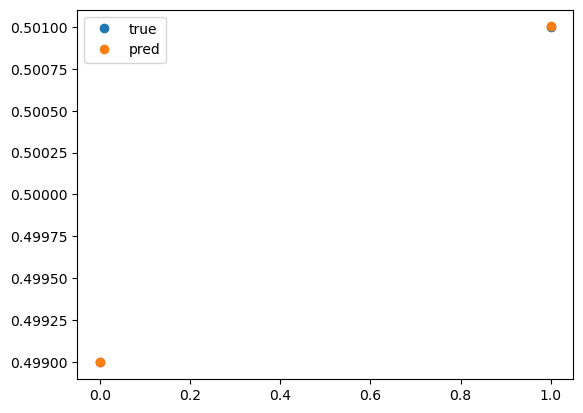

In [16]:
plt.plot(weight_true[true_idx],'o',label='true')   
plt.plot(weight_preds[pred_idx],'o',label='pred')
plt.legend()

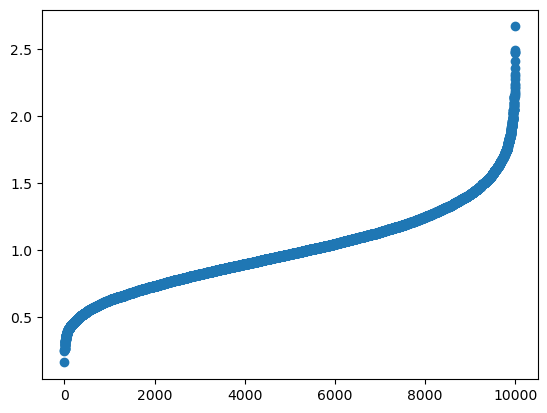

In [12]:
plt.plot(sorted(np.random.dirichlet(np.ones(10000)*10)*10000), 'o')

In [8]:
# Remove GPU cache 
torch.cuda.empty_cache()

In [13]:
del pg
del pg_sol
torch.cuda.empty_cache()

In [25]:
# Test function 

import os
import pickle
import subprocess
import time


def load_pickle_files_and_submit_jobs(directory, sleep_interval=10):
    processed_files = set()

    def get_current_job_count():
        result = subprocess.run(['squeue', '-u', os.getenv('USER')], stdout=subprocess.PIPE)
        job_lines = result.stdout.decode('utf-8').split('\n')
        return len(job_lines) - 1  # Subtracting 1 to exclude the header line
    
    def submit_job(pickle_file):
        slurm_path = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/scripts/slurm/20240625_AnalyzeBGMMfit.sh'
        subprocess.run(['sbatch', slurm_path, pickle_file])

    while True:
        # List all pickle files in the directory with full paths
        pickle_files = [f for f in os.listdir(directory) if f.endswith('.pkl')]
        
        # Check processed files in the results directory
        # List all files in the results directory with full paths
        # Change the file extension to .pkl for comparison with files in pickle_files
        results_dir = os.path.join(directory, 'results')
        processed_file_new = set([f.replace('.txt', '.pkl') for f in os.listdir(results_dir) if f.endswith('.txt')])
        processed_files |= processed_file_new
        print('Processed files: ', len(processed_files), processed_files)
        print('Pickle files: ', len(pickle_files), pickle_files)

        # Filter out files that have already been processed
        new_files = [f for f in pickle_files if f not in processed_files]
        
        print('Number of new files: ', len(new_files))

        # If there are no new files and all files have been processed, break the loop
        if not new_files and all(f in processed_files for f in pickle_files):
            print("All files have been processed and no new files are found.")
            break

        # Submit jobs for new files
        # Submit 100 files at a time
        # Make sure that the number of jobs does not go over 50
        for fi in new_files:
            print(fi)
            # Check if the number of jobs is less than 50
            # print current time 
            print('Current time: ', time.ctime())
            print('Current job count: ', get_current_job_count())
            if get_current_job_count() < 50:
                # submit_job(fi)
                processed_files.add(os.path.join(directory, fi))
            # If the number of jobs is more than 50, break
            else:
                break

        time.sleep(sleep_interval)

        # We can write processed_files in text file somewhere to keep track of processed files

In [26]:
load_pickle_files_and_submit_jobs('/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240627/')

Processed files:  105 {'dataset_100_10_20_100_0_40.0_10000.pkl', 'dataset_100_10_20_10_1000_20.0_10000.pkl', 'dataset_100_10_20_2_0_100.0_10000.pkl', 'dataset_100_10_20_500_1000_10.0_10000.pkl', 'dataset_100_10_20_2_1000_40.0_10000.pkl', 'dataset_100_10_20_5_1000_20.0_10000.pkl', 'dataset_100_10_20_50_0_10.0_10000.pkl', 'dataset_100_10_20_5_1_100.0_10000.pkl', 'dataset_100_10_20_5_1_20.0_10000.pkl', 'dataset_100_10_20_50_1_20.0_10000.pkl', 'dataset_100_10_20_5_1000_10.0_10000.pkl', 'dataset_100_10_20_5_1_2.0_10000.pkl', 'dataset_100_10_20_100_0_100.0_10000.pkl', 'dataset_100_10_20_2_0_2.0_10000.pkl', 'dataset_100_10_20_5_1000_100.0_10000.pkl', 'dataset_100_10_20_2_1_20.0_10000.pkl', 'dataset_100_10_20_10_1000_10.0_10000.pkl', 'dataset_100_10_20_100_1000_2.0_10000.pkl', 'dataset_100_10_20_2_1000_10.0_10000.pkl', 'dataset_100_10_20_250_1_20.0_10000.pkl', 'dataset_100_10_20_50_0_2.0_10000.pkl', 'dataset_100_10_20_500_0_40.0_10000.pkl', 'dataset_100_10_20_50_1000_2.0_10000.pkl', 'dataset_1